In [23]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm
from sklearn.decomposition import PCA
import seaborn as sns

In [24]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 5
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        batch_size = x.shape[0]
        cls_token = self.cls_token.expand(batch_size, -1, -1)

        x = self.patcher(x).permute(0, 2, 1)  # Shape: (batch, num_patches, embed_dim)
        x = torch.cat([cls_token, x], dim=1)  # prepend CLS token
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x

In [26]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True,
        )
        self.encoder_blocks = nn.ModuleList([encoder_layer for _ in range(num_encoders)])

        self.norm = nn.LayerNorm(embed_dim)  # Added final LayerNorm
        self.mlp_head = nn.Sequential(
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x, return_all_layers=False):
        x = self.embeddings_block(x)  # (batch, num_patches+1, embed_dim)

        cls_tokens = []
        patch_tokens = []
        for encoder in self.encoder_blocks:
            x = encoder(x)
            if return_all_layers:
                cls_tokens.append(x[:, 0, :].detach().cpu())           # CLS token after each encoder layer
                patch_tokens.append(x[:, 1:, :].detach().cpu())         # Patch tokens after each encoder layer

        x = self.norm(x)
        if return_all_layers:
            return x[:, 0, :], cls_tokens, patch_tokens  # CLS token final output + intermediate tokens
        else:
            return self.mlp_head(x[:, 0, :])  # Final classification on CLS token only


In [27]:
def cosine_similarity(t1, t2):
    # t1, t2 shape: (batch_size, embed_dim)
    t1_norm = t1 / (t1.norm(dim=1, keepdim=True) + 1e-10)
    t2_norm = t2 / (t2.norm(dim=1, keepdim=True) + 1e-10)
    return (t1_norm * t2_norm).sum(dim=1)  # cosine similarity per batch element


def plot_cls_similarity(cls_tokens):
    """
    Plot average cosine similarity between CLS tokens of consecutive layers.
    cls_tokens: list of tensors with shape (batch_size, embed_dim)
    """
    similarities = []
    for i in range(len(cls_tokens) - 1):
        sim = cosine_similarity(cls_tokens[i], cls_tokens[i + 1]).mean().item()
        similarities.append(sim)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cls_tokens)), similarities, marker='o')
    plt.title("Average Cosine Similarity of CLS Token Between Consecutive Layers")
    plt.xlabel("Layer Index")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.show()


def plot_patch_tokens_pca(patch_tokens, num_samples=100):
    """
    Visualize patch tokens of each layer using PCA.
    patch_tokens: list of tensors (batch_size, num_patches, embed_dim)
    num_samples: number of tokens randomly sampled for visualization
    """
    num_layers = len(patch_tokens)
    plt.figure(figsize=(15, 3 * num_layers))

    for idx, tokens in enumerate(patch_tokens):
        # tokens shape: (batch_size, num_patches, embed_dim)
        # Flatten to (batch_size * num_patches, embed_dim)
        tokens_flat = tokens.reshape(-1, tokens.shape[-1])

        # Sample subset for plotting to reduce clutter
        if tokens_flat.shape[0] > num_samples:
            indices = np.random.choice(tokens_flat.shape[0], num_samples, replace=False)
            tokens_sample = tokens_flat[indices]
        else:
            tokens_sample = tokens_flat

        pca = PCA(n_components=2)
        tokens_2d = pca.fit_transform(tokens_sample)

        plt.subplot(num_layers, 1, idx + 1)
        plt.scatter(tokens_2d[:, 0], tokens_2d[:, 1], alpha=0.6, s=10)
        plt.title(f"PCA of Patch Tokens at Encoder Layer {idx+1}")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [28]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission_df = pd.read_csv("sample_submission.csv")
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [29]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
22460,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20828,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32032,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6194,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12768,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [32]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [33]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        return {"image": image, "label": label, "index": index}

class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        return {"image": image, "label": label, "index": index}

class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)
        return {"image": image, "index": index}


34020
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

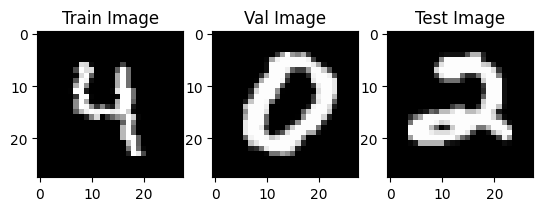

In [34]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [35]:
train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [36]:
# Initialize model, criterion, optimizer as before
model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)


start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].long().to(device)  # changed to long for CrossEntropyLoss

        y_pred = model(img)  # normal forward for training
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].long().to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-" * 30)
    print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch + 1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-" * 30)

stop = timeit.default_timer()
print(f"Training Time: {stop - start:.2f}s")

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [02:47<11:08, 167.06s/it]

------------------------------
Train Loss EPOCH 1: 2.2994
Valid Loss EPOCH 1: 2.2700
Train Accuracy EPOCH 1: 0.1312
Valid Accuracy EPOCH 1: 0.1720
------------------------------


 40%|████      | 2/5 [05:32<08:18, 166.02s/it]

------------------------------
Train Loss EPOCH 2: 2.1245
Valid Loss EPOCH 2: 2.0045
Train Accuracy EPOCH 2: 0.2178
Valid Accuracy EPOCH 2: 0.2892
------------------------------


 60%|██████    | 3/5 [08:07<05:22, 161.25s/it]

------------------------------
Train Loss EPOCH 3: 1.9396
Valid Loss EPOCH 3: 1.8842
Train Accuracy EPOCH 3: 0.3263
Valid Accuracy EPOCH 3: 0.3693
------------------------------


 80%|████████  | 4/5 [10:51<02:42, 162.01s/it]

------------------------------
Train Loss EPOCH 4: 1.7966
Valid Loss EPOCH 4: 1.6758
Train Accuracy EPOCH 4: 0.4194
Valid Accuracy EPOCH 4: 0.4886
------------------------------


100%|██████████| 5/5 [13:33<00:00, 162.78s/it]

------------------------------
Train Loss EPOCH 5: 1.6839
Valid Loss EPOCH 5: 1.5709
Train Accuracy EPOCH 5: 0.4699
Valid Accuracy EPOCH 5: 0.5331
------------------------------
Training Time: 813.92s


In [37]:
torch.cuda.empty_cache()

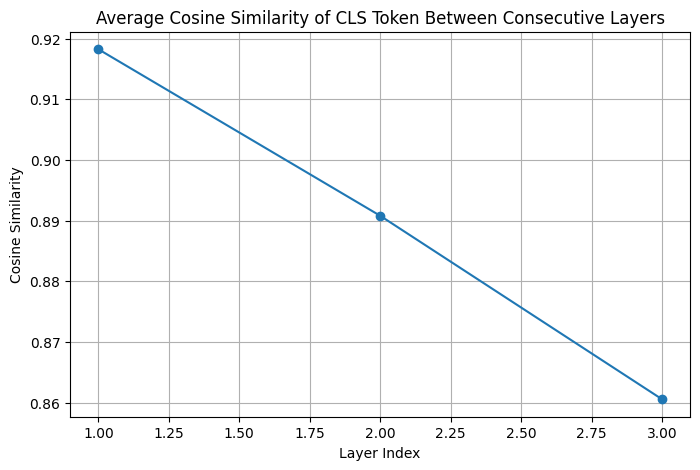

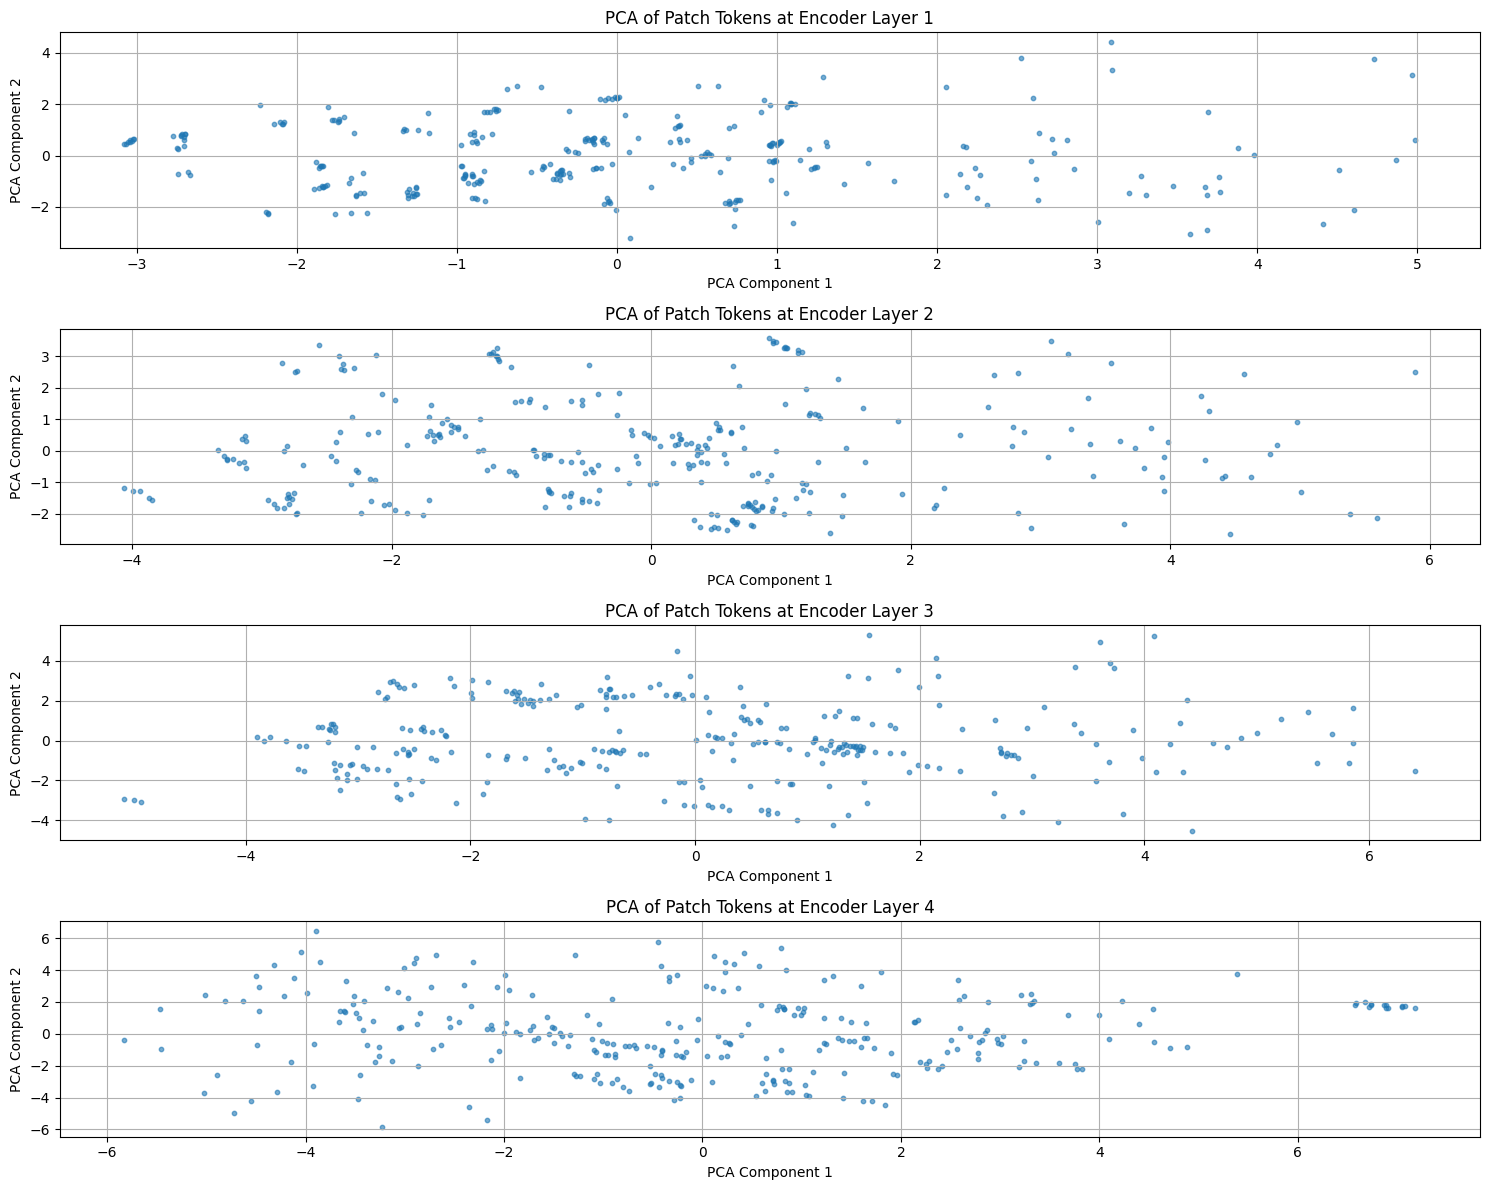

In [38]:
# ======= Visualization after training =======

# Pick a batch of validation images for analysis of tokens evolution
model.eval()
with torch.no_grad():
    # Grab one batch from validation loader
    val_batch = next(iter(val_dataloader))
    val_imgs = val_batch["image"].float().to(device)
    val_labels = val_batch["label"].long().to(device)

    # Get final CLS token, all CLS tokens per layer, and patch tokens per layer
    final_cls_token, all_cls_tokens, all_patch_tokens = model(val_imgs, return_all_layers=True)

# Plot CLS token similarity evolution
plot_cls_similarity(all_cls_tokens)

# Plot patch token PCA evolution
plot_patch_tokens_pca(all_patch_tokens, num_samples=300)

In [39]:
# ======= Inference on test data and submission =======
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])

        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])


100%|██████████| 55/55 [00:24<00:00,  2.27it/s]


<Figure size 640x480 with 0 Axes>

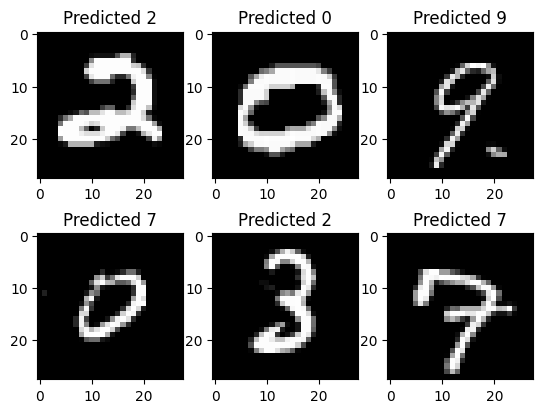

In [40]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

In [41]:
submission_df = pd.DataFrame(list(zip(ids, labels)),
                             columns=["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,2
